In [1]:
library(tidyverse)
library(zoo)
library(lubridate)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




Data

The data catalogued at data.gov and published and hosted by the city of Chicago.
A link to the data can be found at https://data.cityofchicago.org/api/views/6irb-gasv/rows.csv?accessType=DOWNLOAD

In [2]:

covid <- read_csv('https://data.cityofchicago.org/api/views/6irb-gasv/rows.csv?accessType=DOWNLOAD')
covid$Outcome <- as.factor(covid$Outcome)
covid$`Week End` <- mdy(covid$`Week End`)
covid$`Age Group` <- as.factor(covid$`Age Group`)
summary(covid)

Rows: 3753 Columns: 21
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (3): Outcome, Week End, Age Group
dbl (18): Unvaccinated Rate, Vaccinated Rate, Boosted Rate, Crude Vaccinated...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


             Outcome        Week End            Age Group    Unvaccinated Rate
 Cases           :1260   Min.   :2021-04-03   0-4    : 417   Min.   :   0.00  
 Deaths          :1242   1st Qu.:2021-11-27   12-17  : 417   1st Qu.:   0.00  
 Hospitalizations:1251   Median :2022-07-30   18-29  : 417   Median :   9.10  
                         Mean   :2022-07-30   30-49  : 417   Mean   :  72.43  
                         3rd Qu.:2023-04-01   5-11   : 417   3rd Qu.:  64.00  
                         Max.   :2023-12-02   50-64  : 417   Max.   :3690.90  
                                              (Other):1251                    
 Vaccinated Rate    Boosted Rate     Crude Vaccinated Ratio Crude Boosted Ratio
 Min.   :   0.00   Min.   :   0.00   Min.   :  0.000        Min.   : 0.000     
 1st Qu.:   0.00   1st Qu.:   0.00   1st Qu.:  1.300        1st Qu.: 1.000     
 Median :   2.50   Median :   4.00   Median :  2.300        Median : 1.600     
 Mean   :  42.44   Mean   :  48.65   Mean   :  4

EDA

Chicago clearly had a sharp peak in cases, hospitalizations, and deaths at the end of 2021 and beginning of 2022. Deaths significantly decreased in the first half of 2022 but then remained steady throughout the second half of 2022, decreasing again in 2023.  Cases remained high up until December 2023, the end of the dataset.

Warning message:
"Transformation introduced infinite values in continuous y-axis"


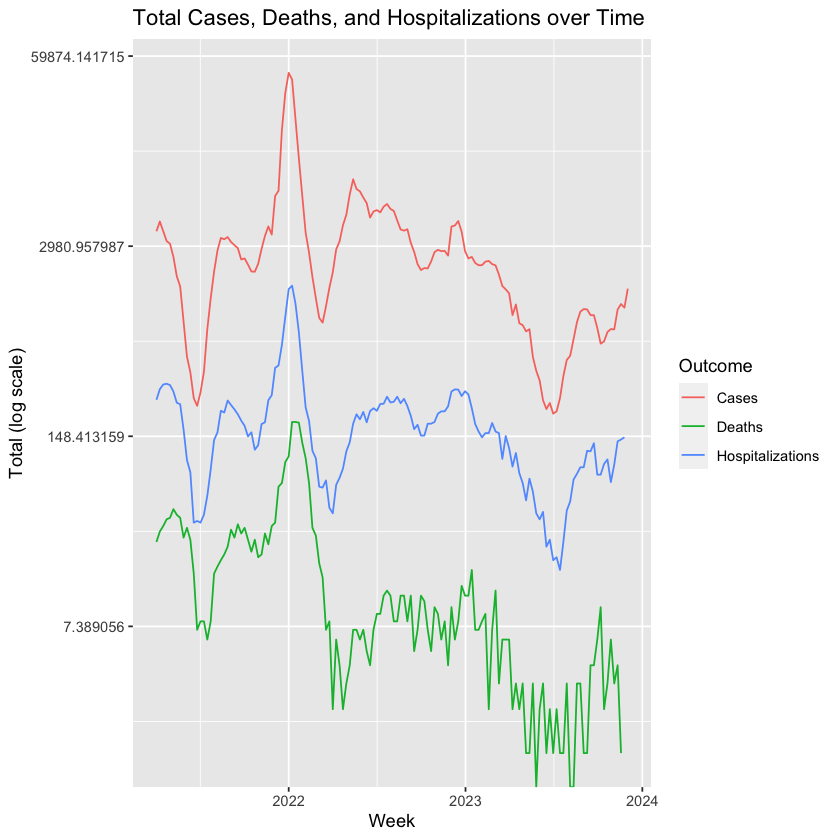

In [3]:
covid %>%
  filter(`Age Group` == 'All') %>%
  mutate(Total = coalesce(`Outcome Unvaccinated`,0) + coalesce(`Outcome Vaccinated`,0) + coalesce(`Outcome Boosted`,0)) %>%
  select(Outcome, `Week End`, Total) %>%
  ggplot() +
  geom_line(aes(x=`Week End`, y=Total, col=Outcome)) +
  scale_y_continuous(trans = "log") +
  labs(x='Week',
       y='Total (log scale)',
       title='Total Cases, Deaths, and Hospitalizations over Time')

Vaccinations grew signficantly in 2021, and by the end of 2021, the rate of boosted population also rapidly grew.

Warning message:
"Removed 29 rows containing missing values (`position_stack()`)."


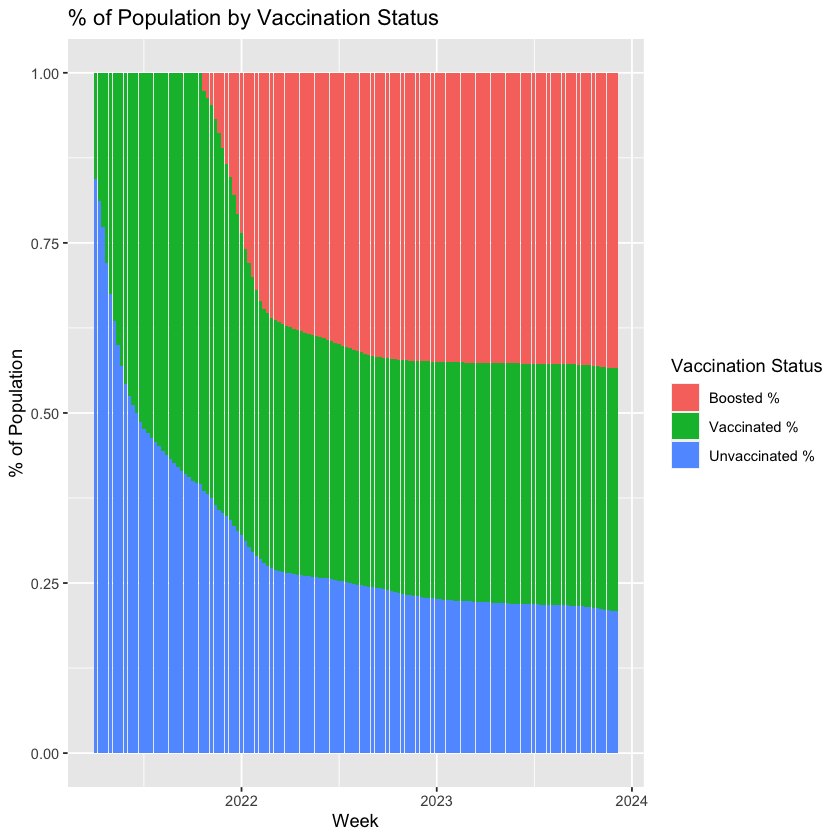

In [4]:
covid %>%
  filter(`Age Group` == 'All', `Outcome` == 'Cases') %>%
  mutate(`Total Population` = coalesce(`Population Unvaccinated`,0) + coalesce(`Population Vaccinated`,0) + coalesce(`Population Boosted`,0)) %>%
  mutate(`Unvaccinated %` = `Population Unvaccinated` / `Total Population`,
         `Vaccinated %` = `Population Vaccinated` / `Total Population`,
         `Boosted %` = `Population Boosted` / `Total Population`) %>%
  select(`Week End`, `Unvaccinated %`, `Vaccinated %`, `Boosted %`) %>%
  pivot_longer(cols=-c('Week End'),
               names_to="Vaccination Status",
               values_to="%") %>%
  ggplot() +
  geom_bar(aes(x=`Week End`, y=`%`, fill=factor(`Vaccination Status`, levels=c('Boosted %', 'Vaccinated %', 'Unvaccinated %'))),position='stack', stat='identity') +
  scale_fill_discrete(name='Vaccination Status', breaks=c('Boosted %', 'Vaccinated %', 'Unvaccinated %')) + 
  labs(x='Week',
       y='% of Population',
       title='% of Population by Vaccination Status')

Models

Predict cases, hospitalizations, and deaths 14 days in the future using the past 14 days of cases, plus the current day's vaccination and boosted rate.

In [5]:
dataset <- covid %>%
  filter(`Age Group` == 'All') %>%
  mutate(`Total Population` = coalesce(`Population Unvaccinated`,0) + coalesce(`Population Vaccinated`,0) + coalesce(`Population Boosted`,0)) %>%
  mutate(Total = coalesce(`Outcome Unvaccinated`,0) + coalesce(`Outcome Vaccinated`,0) + coalesce(`Outcome Boosted`,0)) %>%
  mutate(`Vaccinated %` = coalesce(`Population Vaccinated`,0) / `Total Population`,
         `Boosted %` = coalesce(`Population Boosted`,0) / `Total Population`) %>%
  select(`Week End`, `Outcome`, `Total`, `Total Population`, `Vaccinated %`, `Boosted %`) %>%
  pivot_wider(names_from = 'Outcome',
              values_from = 'Total') %>%
  arrange(`Week End`) %>%
  mutate(lag1_Cases = lag(Cases, 1),
         lag2_Cases = lag(Cases, 2),
         lag3_Cases = lag(Cases, 3),
         lag4_Cases = lag(Cases, 4),
         lag5_Cases = lag(Cases, 5),
         lag6_Cases = lag(Cases, 6),
         lag7_Cases = lag(Cases, 7),
         lag8_Cases = lag(Cases, 8),
         lag1_Hospitalizations = lag(Hospitalizations, 1),
         lag2_Hospitalizations = lag(Hospitalizations, 2),
         lag3_Hospitalizations = lag(Hospitalizations, 3),
         lag4_Hospitalizations = lag(Hospitalizations, 4),
         lag5_Hospitalizations = lag(Hospitalizations, 5),
         lag6_Hospitalizations = lag(Hospitalizations, 6),
         lag7_Hospitalizations = lag(Hospitalizations, 7),
         lag8_Hospitalizations = lag(Hospitalizations, 8),
         lag1_Deaths = lag(Deaths, 1),
         lag2_Deaths = lag(Deaths, 2),
         lag3_Deaths = lag(Deaths, 3),
         lag4_Deaths = lag(Deaths, 4),
         lag5_Deaths = lag(Deaths, 5),
         lag6_Deaths = lag(Deaths, 6),
         lag7_Deaths = lag(Deaths, 7),
         lag8_Deaths = lag(Deaths, 8),
         roll4Deaths = (coalesce(lead(Deaths,1),0) + coalesce(lead(Deaths, 2),0) + coalesce(lead(Deaths, 3),0) + coalesce(lead(Deaths, 4),0))/4) %>%
  filter(row_number() <= n()-9) %>%
  filter(row_number() >= 9)

train <- dataset %>%
  filter(`Week End` < '2023-01-01')

model <- lm(roll4Deaths ~ . - `Week End`, data = train)
summary(model)


Call:
lm(formula = roll4Deaths ~ . - `Week End`, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.7285  -3.8573  -0.8144   3.2945  18.3130 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            1.799e+02  1.856e+02   0.969 0.336713    
`Total Population`    -8.357e-05  8.147e-05  -1.026 0.309645    
`Vaccinated %`         6.566e+01  5.757e+01   1.140 0.259234    
`Boosted %`            2.496e+01  2.220e+01   1.125 0.265839    
Deaths                 1.022e+00  2.433e-01   4.198 0.000103 ***
Hospitalizations       9.062e-02  3.469e-02   2.612 0.011676 *  
Cases                  2.298e-03  9.516e-04   2.415 0.019220 *  
lag1_Cases            -4.442e-03  1.466e-03  -3.030 0.003778 ** 
lag2_Cases            -2.486e-03  1.544e-03  -1.610 0.113424    
lag3_Cases            -9.115e-04  1.757e-03  -0.519 0.606105    
lag4_Cases             5.313e-03  1.847e-03   2.877 0.005781 ** 
lag5_Cases            -7.213e-04  2.0

In [6]:
test <- dataset %>%
  filter(`Week End` >= '2023-01-01')

test$pred = predict(model, test)

rsme = sqrt(mean((test$roll4Deaths-test$pred)^2))
paste('rsme:', rsme, ', mean 4-day future death average:', mean(test$roll4Deaths))

[1] "rsme: 9.38226189361396 , mean 4-day future death average: 3.60897435897436"

Discussion

The results of the linear model show that future Covid deaths are difficult to predict from just the linear model alone.  The linear model tends to overfit the data in this case, as can be seen from the high r-squared statistic from the training set, but root mean squared error on the test set is still quite high.  Test prediction are also often negative, suggesting the simple linear model is not suitable for this dataset.